# The Milky Way potential using Barros' 2016 model

We compare the best model from Barros (2016, henceforth B16) with and without central holes
in the HI or H2 gas.

We plot the potential, density, enclosed mass profiles, and rotation curves.

> Note: All the internal workings are in units $M_\odot$, kpc, Myr (as in the C++ code).
Conversions for velocities can be applied with the helpful `GalaxyPotential` value `kpc_Myr_to_km_s` ($=977.77$)

In [29]:
# Some helpful imports
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

import mpl_aesth
mpl_aesth.adjust_rcParams('seaborn', use_kpfonts=True, dark_mode=False)

cl = mpl_aesth.c.copy()

# TODO: Change these so that we also have different colors for R and z profiles
# Linecolors
c = {
   'tot': mpl_aesth.c[3],
   'thin': mpl_aesth.c[1],
   'thick': mpl_aesth.c[2],
   'HI': mpl_aesth.c[0],
   'H2': mpl_aesth.c[5],
   'bul': mpl_aesth.c[6],
   'DM': mpl_aesth.c[7]
}
# Linestyles
ls = {
   'bf': '-',     # Best fit
   'nh': '--',    # No hole
   'nHIh': '-.',  # No HI hole
}

import norm
import physconst as pc
nm = norm.PhysNorm(m=pc.msun, x=pc.kpc, t=pc.Myr, temp=1., curr=1.)

## Calculating the potential

Load the potential and density profiles functions

In [30]:
import Barros_functions as Bar
Phi = Bar.BarrosMW("pot/BAR16_best.Bpot")
Phi_nh = Bar.BarrosMW("pot/BAR16_best_nohole.Bpot")
Phi_nHIh = Bar.BarrosMW("pot/BAR16_best_noHIhole.Bpot")
vconv = Phi.kpc_Myr_to_km_s
phi_plt_norm = vconv ** 2 / 1.e5   # in units of (100 km/s)^2

## The domain

In [31]:
R_min, R_max, nR = 0.1, 30, 1000
z_min, z_max, nz = 0.1, 30, 1000
R = np.linspace(R_min, R_max, nR)
z = np.linspace(z_min, z_max, nz)
RR, zz = np.meshgrid(R, z)
RR, zz = RR.ravel(), zz.ravel()
R0, z0 = np.zeros_like(R), np.zeros_like(z)
Rp01, Rp03, Rp1, Rp3, = 0.01 * np.ones_like(R), 0.03 * np.ones_like(R), 0.1 * np.ones_like(R), 0.3 * np.ones_like(R)
R1, R2, R4, R8 = 1. * np.ones_like(R), 2. * np.ones_like(R), 4. * np.ones_like(R), 8. * np.ones_like(R)

## Potential as functions of R and z

The following plots show the potential due to all components of the model galaxy

### Potential of R along z = 0, and potential of z along R = 0.

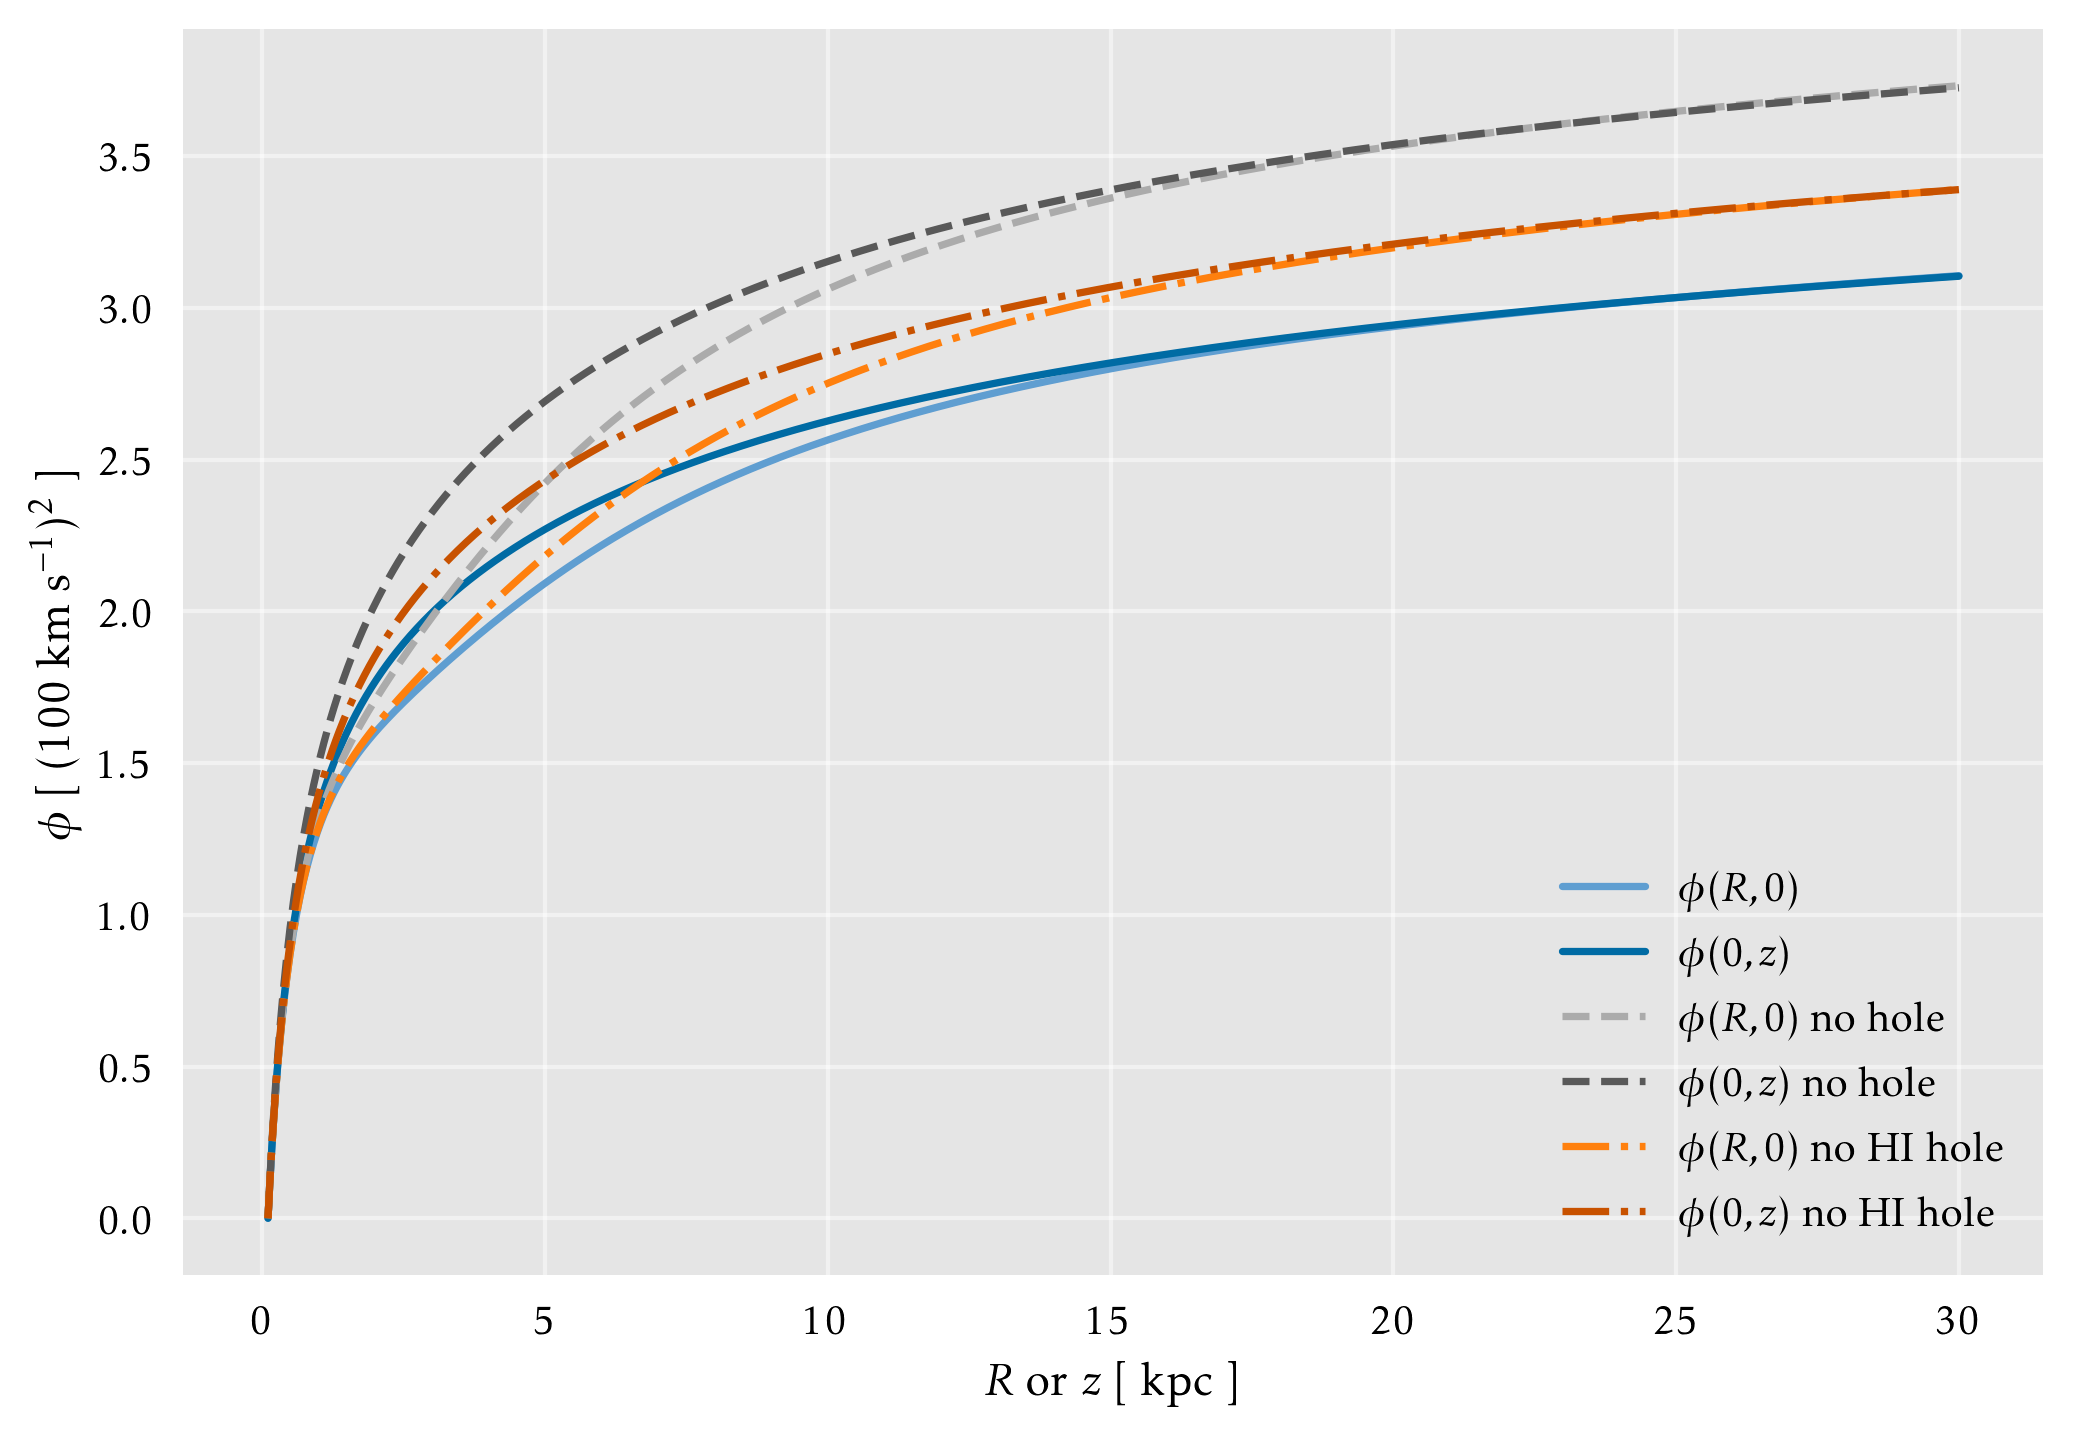

In [32]:
pot_r = Phi.total_potential(R, z0) * phi_plt_norm
pot_z = Phi.total_potential(R0, z) * phi_plt_norm
pot_r_nh = Phi_nh.total_potential(R, z0) * phi_plt_norm
pot_z_nh = Phi_nh.total_potential(R0, z) * phi_plt_norm
pot_r_nHIh = Phi_nHIh.total_potential(R, z0) * phi_plt_norm
pot_z_nHIh = Phi_nHIh.total_potential(R0, z) * phi_plt_norm
pot_r -= pot_r[0]
pot_z -= pot_z[0]
pot_r_nh -= pot_r_nh[0]
pot_z_nh -= pot_z_nh[0]
pot_r_nHIh -= pot_r_nHIh[0]
pot_z_nHIh -= pot_z_nHIh[0]
plt.plot(R, pot_r, c=cl[4], label=r'$\phi(R, 0)$')
plt.plot(z, pot_z, c=cl[0], label=r'$\phi(0, z)$')
plt.plot(R, pot_r_nh, c=cl[2], ls=ls['nh'], label=r'$\phi(R, 0)$ no hole')
plt.plot(z, pot_z_nh, c=cl[3], ls=ls['nh'], label=r'$\phi(0, z)$ no hole')
plt.plot(R, pot_r_nHIh, c=cl[1], ls=ls['nHIh'], label=r'$\phi(R, 0)$ no HI hole')
plt.plot(z, pot_z_nHIh, c=cl[5], ls=ls['nHIh'], label=r'$\phi(0, z)$ no HI hole')
plt.xlabel(r'$R$ or $z$ [ kpc ]')
plt.ylabel(r'$\phi$ [ (100 km s$^{-1}$)$^2$ ]')
# plt.semilogx()
plt.legend()
plt.show()

### Two-dimensional potential 

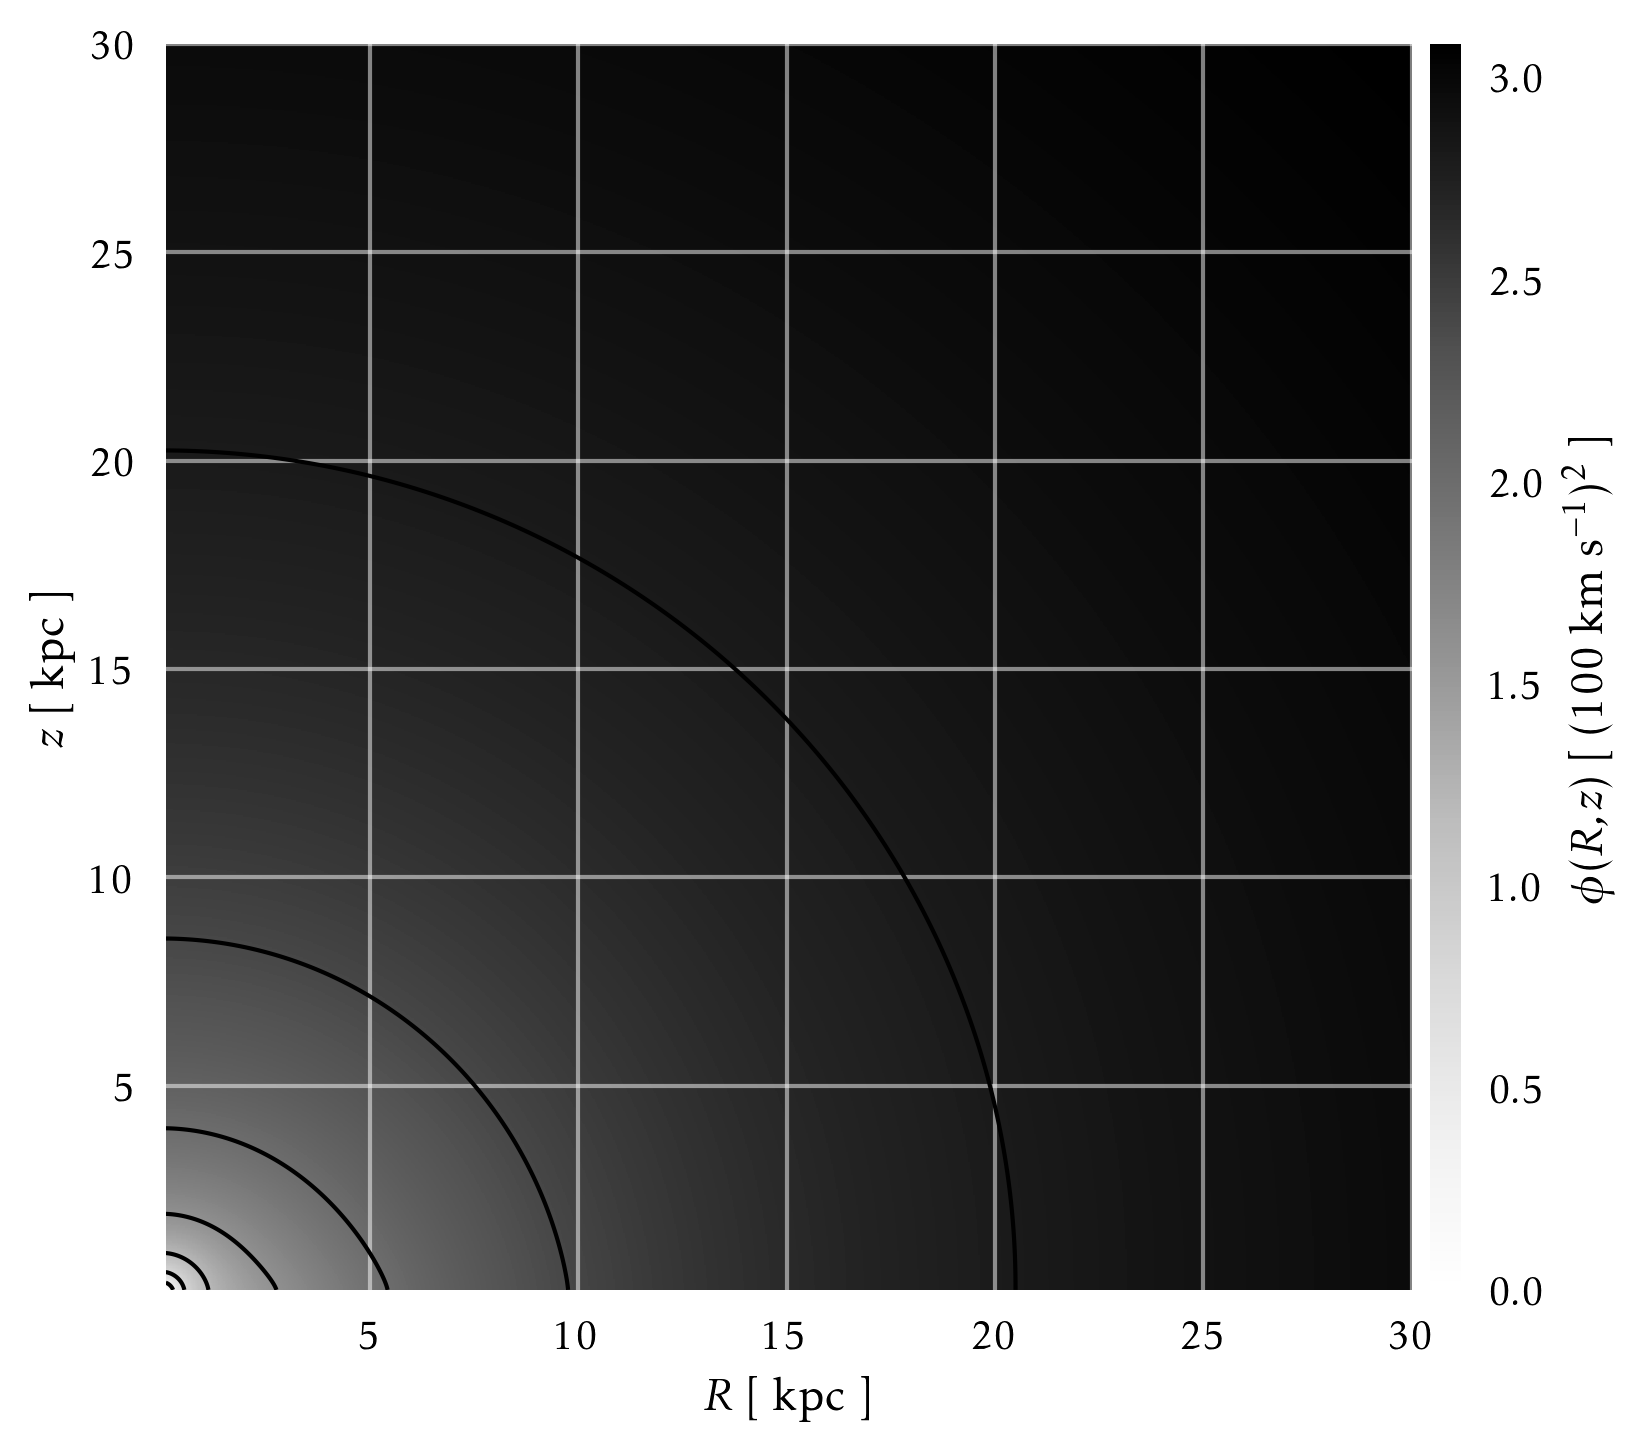

In [33]:
pot_2d = Phi.total_potential(RR, zz).reshape(nR, nz) * phi_plt_norm
pot_2d -= pot_2d[0, 0]
# pot_2d_nh = Phi_nh.total_potential(RR, zz).reshape(nR, nz) * phi_plt_norm
# pot_2d_nh -= pot_2d_nh[0, 0]
# pot_2d_nHIh = Phi_nHIh.total_potential(RR, zz).reshape(nR, nz) * phi_plt_norm
# pot_2d_nHIh -= pot_2d_nHIh[0, 0]

plt.imshow(pot_2d, origin='lower', extent=[R_min, R_max, z_min, z_max])
plt.gca().set_aspect('equal')
plt.colorbar(label=r'$\phi(R, z)$ [ (100 km s$^{-1}$)$^2$ ]', pad=0.01, aspect=40)
plt.contour(R, z, pot_2d, colors='k', linewidths=1)
plt.xlabel(r'$R$ [ kpc ]')
plt.ylabel(r'$z$ [ kpc ]')
plt.show()

## Derivatives wrt R & z of potential

In [34]:
# dphidr = Phi.total_potential_derivatives(RR, zz)

## Density as functions of R for different components

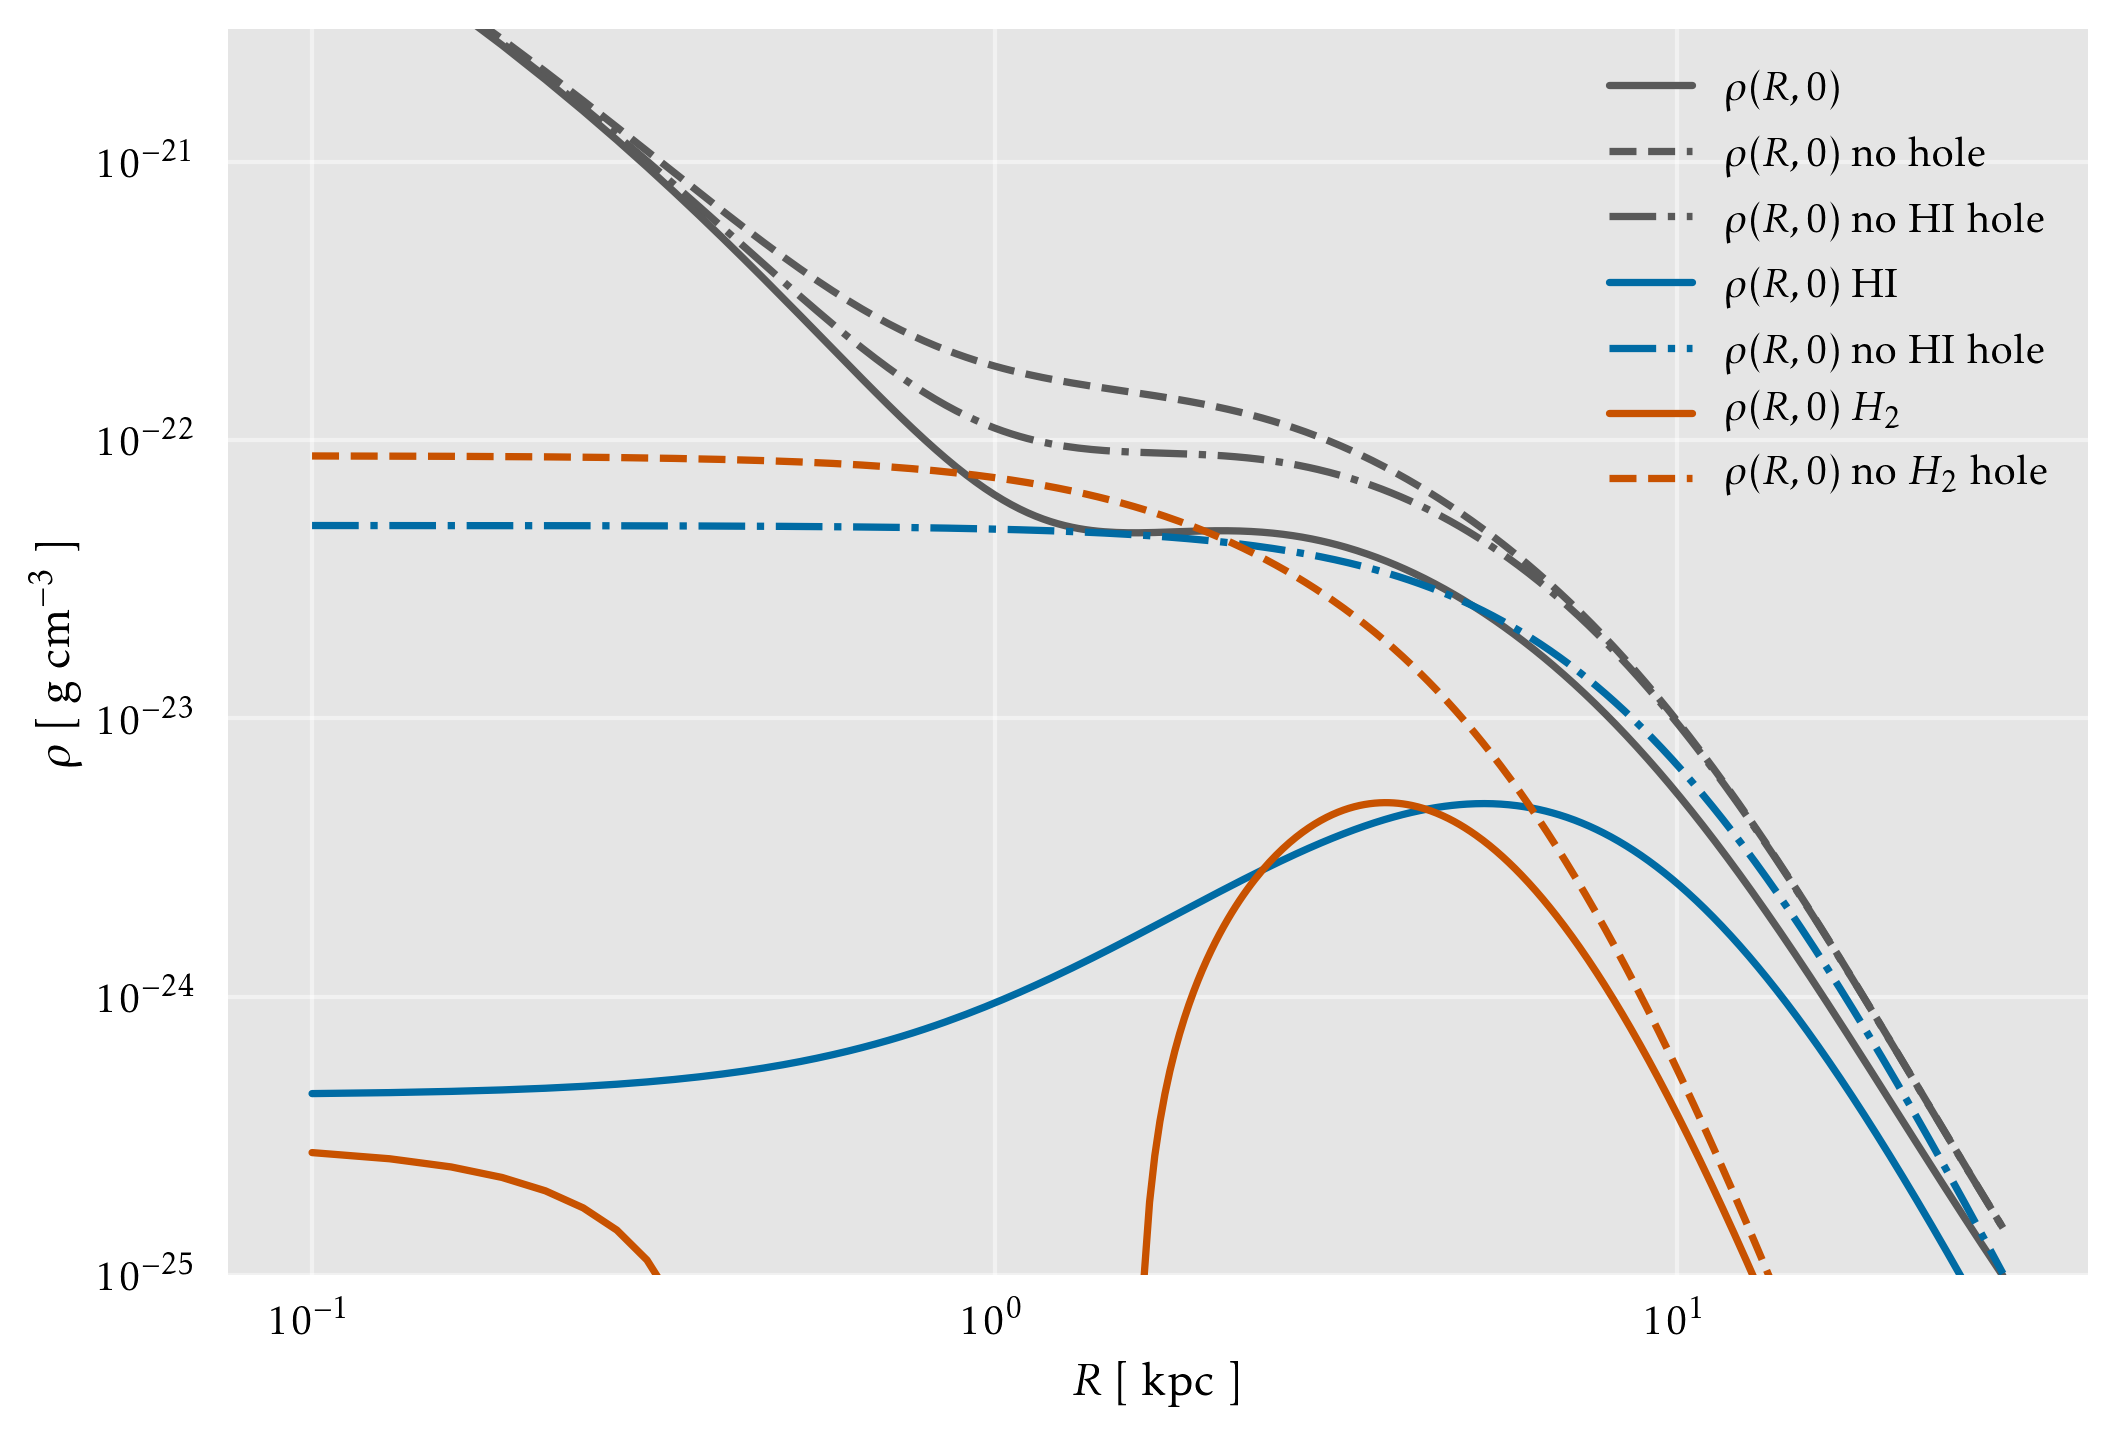

In [35]:
plt.plot(R, Phi.total_density(R, z0) * nm.dens, c=c['tot'], ls=ls['bf'], label=r'$\rho(R, 0)$')
plt.plot(R, Phi_nh.total_density(R, z0) * nm.dens, c=c['tot'], ls=ls['nh'], label=r'$\rho(R, 0)$ no hole')
plt.plot(R, Phi_nHIh.total_density(R, z0) * nm.dens, c=c['tot'], ls=ls['nHIh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Phi.HI_disc_density(R, z0) * nm.dens, c=c['HI'], ls=ls['bf'], label=r'$\rho(R, 0)$ HI')
plt.plot(R, Phi_nh.HI_disc_density(R, z0) * nm.dens, c=c['HI'], ls=ls['nHIh'], label=r'$\rho(R, 0)$ no HI hole')
plt.plot(R, Phi.H2_disc_density(R, z0) * nm.dens, c=c['H2'], ls=ls['bf'], label=r'$\rho(R, 0)$ $H_2$')
plt.plot(R, Phi_nh.H2_disc_density(R, z0) * nm.dens, c=c['H2'], ls=ls['nh'], label=r'$\rho(R, 0)$ no $H_2$ hole')
# plt.semilogy()
plt.loglog()
plt.ylim(1.e-25, 3.e-21)
plt.xlabel('$R$ [ kpc ]')
plt.ylabel(r'$\rho$ [ g cm$^{-3}$ ]')
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1.0))
plt.show()

## Density as functions of z at R = Rs for different components

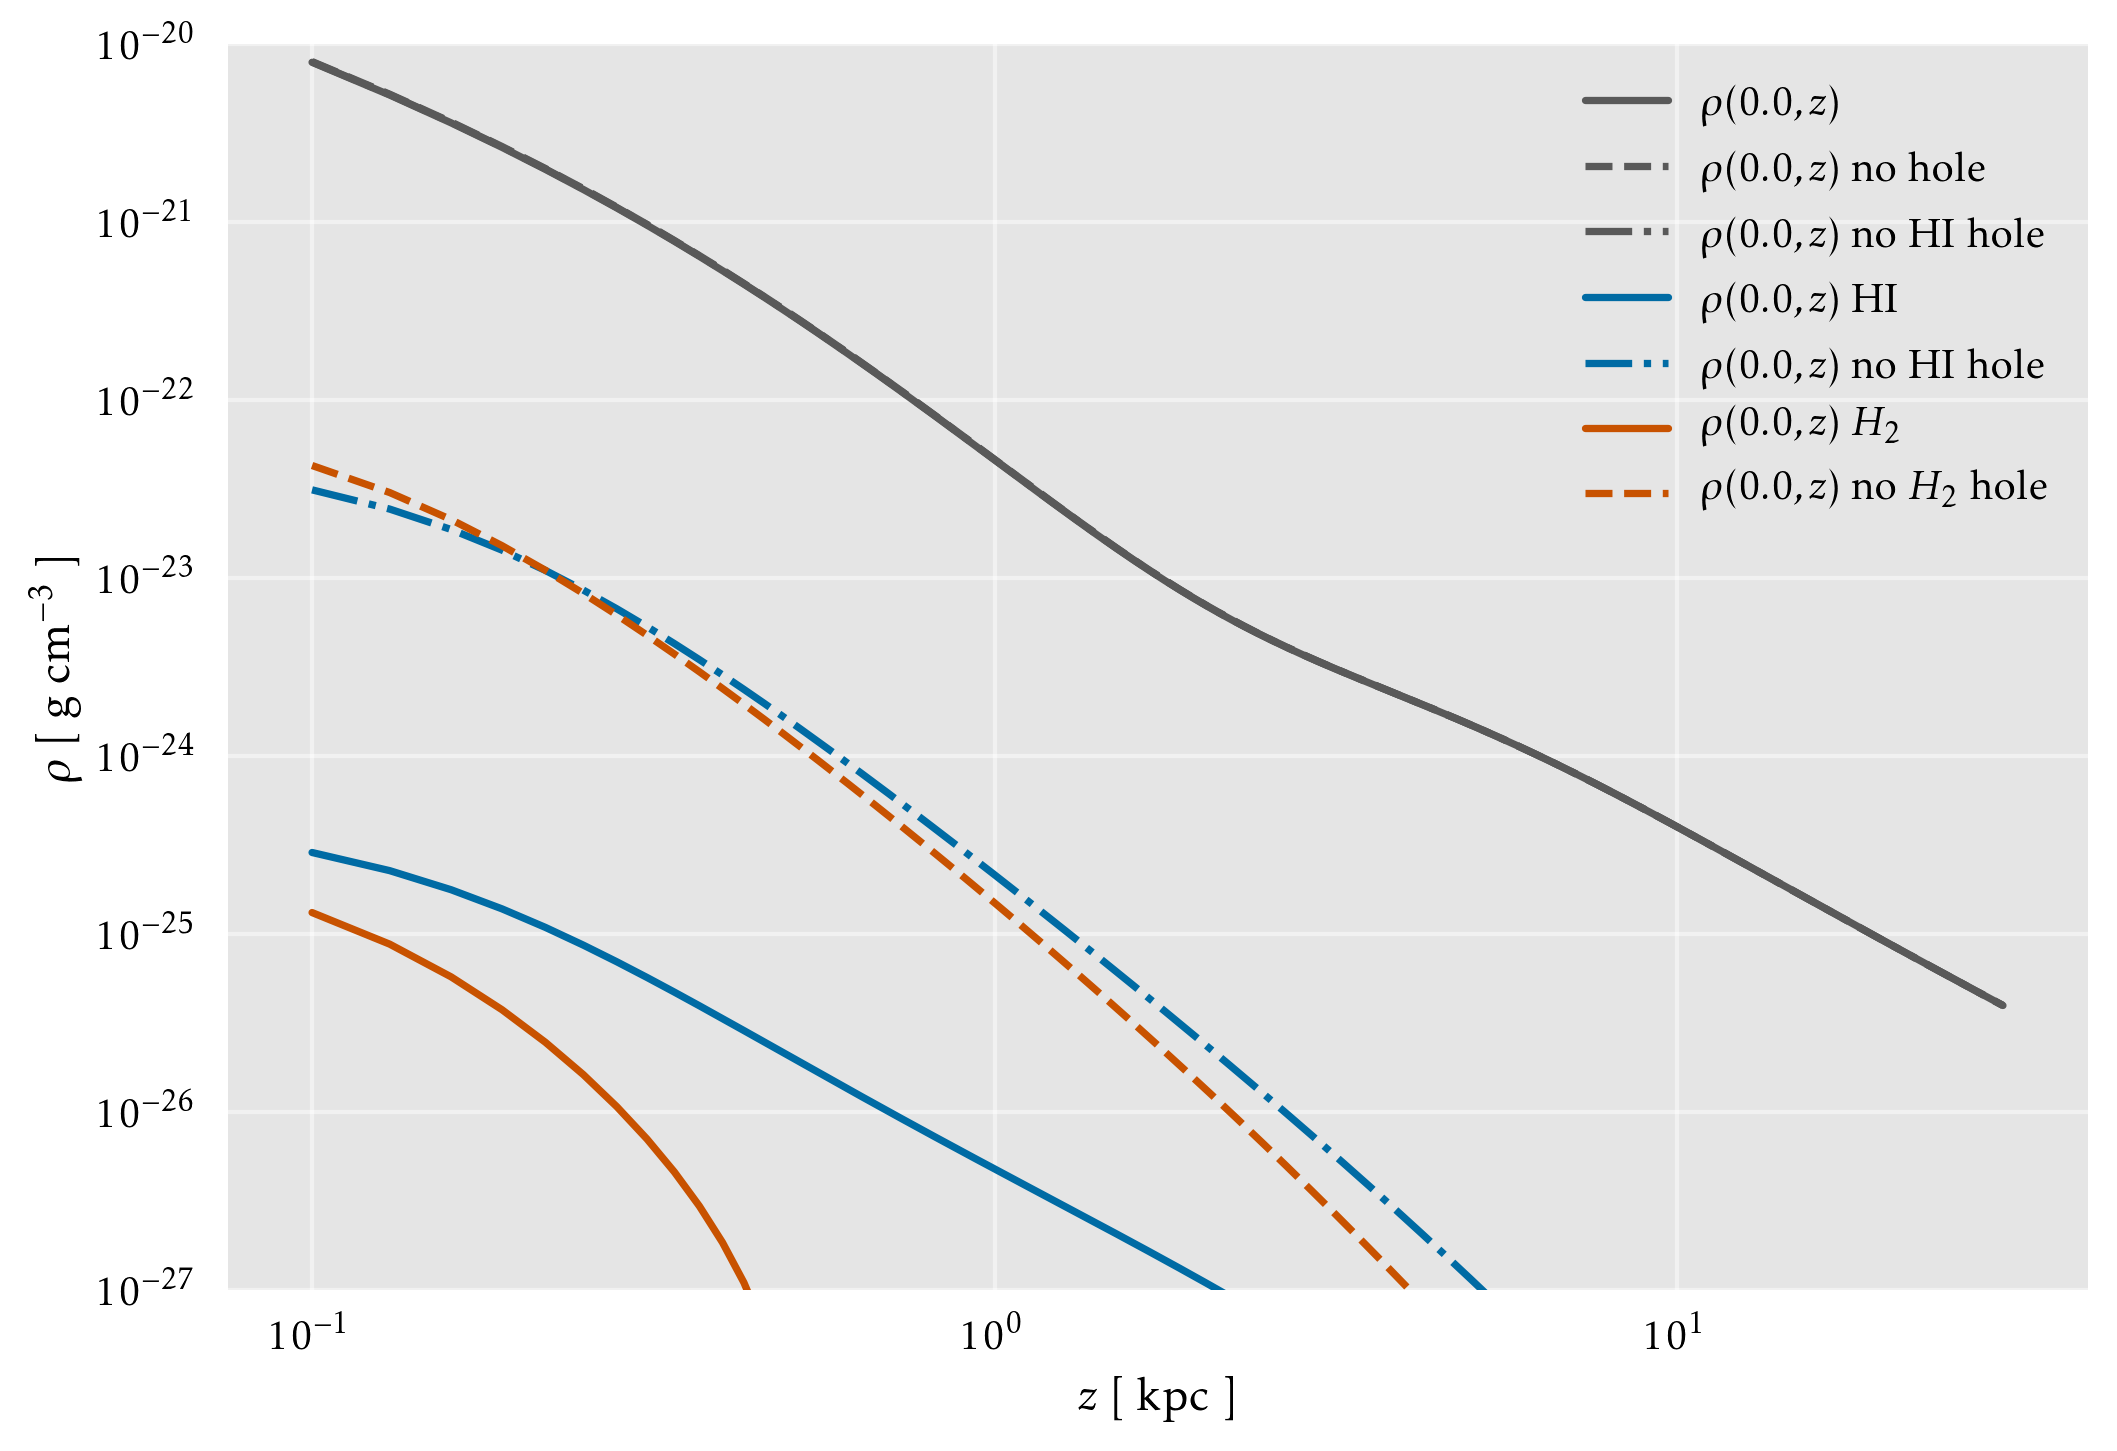

In [41]:
Rs = R0
plt.plot(z, Phi.total_density(Rs, z) * nm.dens, c=c['tot'], ls=ls['bf'], label=rf'$\rho({Rs[0]}, z)$')
plt.plot(z, Phi_nh.total_density(Rs, z) * nm.dens, c=c['tot'], ls=ls['nh'], label=rf'$\rho({Rs[0]}, z)$ no hole')
plt.plot(z, Phi_nHIh.total_density(Rs, z) * nm.dens, c=c['tot'], ls=ls['nHIh'], label=rf'$\rho({Rs[0]}, z)$ no HI hole')
plt.plot(z, Phi.HI_disc_density(Rs, z) * nm.dens, c=c['HI'], ls=ls['bf'], label=rf'$\rho({Rs[0]}, z)$ HI')
plt.plot(z, Phi_nh.HI_disc_density(Rs, z) * nm.dens, c=c['HI'], ls=ls['nHIh'], label=rf'$\rho({Rs[0]}, z)$ no HI hole')
plt.plot(z, Phi.H2_disc_density(Rs, z) * nm.dens, c=c['H2'], ls=ls['bf'], label=rf'$\rho({Rs[0]}, z)$ $H_2$')
plt.plot(z, Phi_nh.H2_disc_density(Rs, z) * nm.dens, c=c['H2'], ls=ls['nh'], label=rf'$\rho({Rs[0]}, z)$ no $H_2$ hole')
# plt.semilogy()
plt.loglog()
# plt.xlim(0, 1)
plt.ylim(1.e-27, 1.e-20)
plt.xlabel('$z$ [ kpc ]')
plt.ylabel(r'$\rho$ [ g cm$^{-3}$ ]')
plt.legend()
# plt.legend(loc='upper left', bbox_to_anchor=(1.04, 1.0))
plt.show()

## Enclosed mass as a function of spherical radius (not scripted yet)

In [37]:
# plt.plot(R, Phi.mass(R) / 1.e11, c=c['tot'], ls=ls['bf'], label='best fit')
# plt.plot(R, Phi_nh.mass(R) / 1.e11, c=c['tot'], ls=ls['nh'], label='no hole')
# plt.plot(R, Phi_nHIh.mass(R) / 1.e11, c=c['tot'], ls=ls['nHIh'], label='no HI hole')
# plt.xlabel('$R$ [ kpc ]')
# plt.ylabel(r'Enclosed mass [ 10$^{11}$ M$_\odot$ ]')
# plt.legend()
# plt.show()

## Rotation curve (not scripted yet)

In [38]:
# plt.plot(R, Phi.Vcirc(R) * vconv, c=c['tot'], ls=ls['bf'], label='best fit')
# plt.plot(R, Phi_nh.Vcirc(R) * vconv, c=c['tot'], ls=ls['nh'], label='no hole')
# plt.plot(R, Phi_nHIh.Vcirc(R) * vconv, c=c['tot'], ls=ls['nHIh'], label='no HI hole')
# plt.xlabel('$R$ [ kpc ]')
# plt.ylabel(r'$v_c$ [ km s$^{-1}$ ]')
# plt.legend()
# plt.show()
